In [23]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit


In [24]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [25]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [26]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])
subject_df = subject_df.drop(["Unnamed: 0.1"], axis=1)

In [27]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [28]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [29]:
stattranstrees_dic =  {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1-Score': []
}

In [30]:
indaccs_dic = {}

#Decision Tree
DT_results = []
X=subject_df.iloc[:, 2:11]
Y=subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for d in range(1, 26):
    model=DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Max Depth: {}'.format(d))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    DT_results.append(scores.mean())
print(DT_results)

In [31]:
#Decision Tree 
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=DecisionTreeClassifier(max_depth=8)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattranstrees_dic['Run Time'].append(elapsed)
stattranstrees_dic['Accuracy'].append(np.mean(acc_score))
stattranstrees_dic['Standard Error'].append(np.std(acc_score))
stattranstrees_dic['Sensitivity'].append(sensitivity)
stattranstrees_dic['Specificity'].append(specificity)
stattranstrees_dic['Precision'].append(precision)
stattranstrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Decision Tree']=acc_score

---Run time is 1.234015134999936 seconds ---

Accuracy of each fold: 
 [0.944538591896472, 0.9456086286594761, 0.9485362095531588, 0.9486902927580894, 0.9543913713405239]
Avg accuracy: 0.948353018841544
Std of accuracy : 
0.003426092346223658

[[18423  1003]
 [  673 12352]]

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     19426
           1       0.92      0.95      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.94      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9483681663749614
0.9483301343570057
0.964757017176372
0.9564923939567


In [32]:
#Bagging
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=RandomForestClassifier(max_features=9, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattranstrees_dic['Run Time'].append(elapsed)
stattranstrees_dic['Accuracy'].append(np.mean(acc_score))
stattranstrees_dic['Standard Error'].append(np.std(acc_score))
stattranstrees_dic['Sensitivity'].append(sensitivity)
stattranstrees_dic['Specificity'].append(specificity)
stattranstrees_dic['Precision'].append(precision)
stattranstrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Bagging']=acc_score

---Run time is 92.16161547999945 seconds ---

Accuracy of each fold: 
 [0.9468494839007857, 0.9519260400616333, 0.9505392912172573, 0.9539291217257319, 0.9560862865947611]
Avg accuracy: 0.9518660447000338
Std of accuracy : 
0.0031303828827796906

[[18523   903]
 [  659 12366]]

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19426
           1       0.93      0.95      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.95      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.953515906517039
0.949404990403071
0.9656448754040247
0.9595420638209697


In [33]:
#Random Forest
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=RandomForestClassifier(max_features=3, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattranstrees_dic['Run Time'].append(elapsed)
stattranstrees_dic['Accuracy'].append(np.mean(acc_score))
stattranstrees_dic['Standard Error'].append(np.std(acc_score))
stattranstrees_dic['Sensitivity'].append(sensitivity)
stattranstrees_dic['Specificity'].append(specificity)
stattranstrees_dic['Precision'].append(precision)
stattranstrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Random Forest']=acc_score

---Run time is 43.46707387799688 seconds ---

Accuracy of each fold: 
 [0.9485441380372824, 0.9546995377503852, 0.9517719568567026, 0.9539291217257319, 0.9562403697996918]
Avg accuracy: 0.9530370248339587
Std of accuracy : 
0.0026686188857126428

[[18524   902]
 [  622 12403]]

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19426
           1       0.93      0.95      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.95      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9535673839184597
0.9522456813819578
0.9675127964065601
0.9604894742300114


#Ada Boosting
AdaBoostResults = []
X=subject_df.iloc[:, 2:11]
Y=subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for r in range(-2, 2):
    model=AdaBoostClassifier(n_estimators=500, learning_rate=10**r, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Learning rate: {}'.format(10**r))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    AdaBoostResults.append(scores.mean())
print(AdaBoostResults)

#Ada Boosting
AdaBoostResults2 = []
X=subject_df.iloc[:, 2:11]
Y=subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for r in range(2,10):
    model=AdaBoostClassifier(n_estimators=500, learning_rate=0.1*r, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Learning rate: {}'.format(0.1*r))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    AdaBoostResults2.append(scores.mean())
print(AdaBoostResults2)

In [34]:
#Ada Boosting
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=AdaBoostClassifier(n_estimators=500, learning_rate=0.3, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattranstrees_dic['Run Time'].append(elapsed)
stattranstrees_dic['Accuracy'].append(np.mean(acc_score))
stattranstrees_dic['Standard Error'].append(np.std(acc_score))
stattranstrees_dic['Sensitivity'].append(sensitivity)
stattranstrees_dic['Specificity'].append(specificity)
stattranstrees_dic['Precision'].append(precision)
stattranstrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Ada Boosting']=acc_score

---Run time is 141.8297291400013 seconds ---

Accuracy of each fold: 
 [0.9453088892312432, 0.9491525423728814, 0.9469953775038521, 0.9491525423728814, 0.9485362095531588]
Avg accuracy: 0.9478291122068034
Std of accuracy : 
0.0014865772006619645

[[18480   946]
 [  747 12278]]

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     19426
           1       0.93      0.94      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.94      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9513023782559457
0.9426487523992323
0.9611483850834763
0.9562000362196983


#Gradient Boosting
GBresults_lr = []
X=subject_df.iloc[:, 2:11]
Y=subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for r in range(1, 7):
    model=GradientBoostingClassifier(n_estimators=500, learning_rate=0.1*r, max_depth=4, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Learning rate: {}'.format(0.1*r))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    GBresults_lr.append(scores.mean())
print(GBresults_lr)

#Gradient Boosting
GBresults_md = []
X=subject_df.iloc[:, 2:11]
Y=subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for d in range(1, 26):
    model=GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=d, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Max depth: {}'.format(d))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    GBresults_md.append(scores.mean())
print(GBresults_md)

In [35]:
#Gradient Boosting
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=GradientBoostingClassifier(n_estimators=500, learning_rate=0.1 , max_depth=3, random_state=3)
start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattranstrees_dic['Run Time'].append(elapsed)
stattranstrees_dic['Accuracy'].append(np.mean(acc_score))
stattranstrees_dic['Standard Error'].append(np.std(acc_score))
stattranstrees_dic['Sensitivity'].append(sensitivity)
stattranstrees_dic['Specificity'].append(specificity)
stattranstrees_dic['Precision'].append(precision)
stattranstrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Gradient Boosting']=acc_score

---Run time is 135.50444719999723 seconds ---

Accuracy of each fold: 
 [0.9523956247111385, 0.9531587057010786, 0.9543913713405239, 0.9553158705701078, 0.9562403697996918]
Avg accuracy: 0.9543003884245082
Std of accuracy : 
0.001395318878238612

[[18546   880]
 [  603 12422]]

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19426
           1       0.93      0.95      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.95      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9546998867497168
0.953704414587332
0.9685101049663167
0.9615554115359688


In [36]:
transitionstreesdf = pd.DataFrame(
    data = np.transpose(np.array([
                                stattranstrees_dic["Accuracy"],
                                stattranstrees_dic["Standard Error"],
                                stattranstrees_dic["Sensitivity"],
                                stattranstrees_dic["Specificity"],
                                stattranstrees_dic["Precision"],
                                stattranstrees_dic["F1-Score"],
                                stattranstrees_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionstreesdf.set_index(pd.Index(["DecisionTree", "Bagging", "RandomForest", "AdaBoosting", "GradientBoosting"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
DecisionTree,0.948353,0.003426,0.948368,0.948330,0.964757,0.956492,1.234015
Bagging,0.951866,0.003130,0.953516,0.949405,0.965645,0.959542,92.161615
RandomForest,0.953037,0.002669,0.953567,0.952246,0.967513,0.960489,43.467074
AdaBoosting,0.947829,0.001487,0.951302,0.942649,0.961148,0.956200,141.829729
GradientBoosting,0.954300,0.001395,0.954700,0.953704,0.968510,0.961555,135.504447


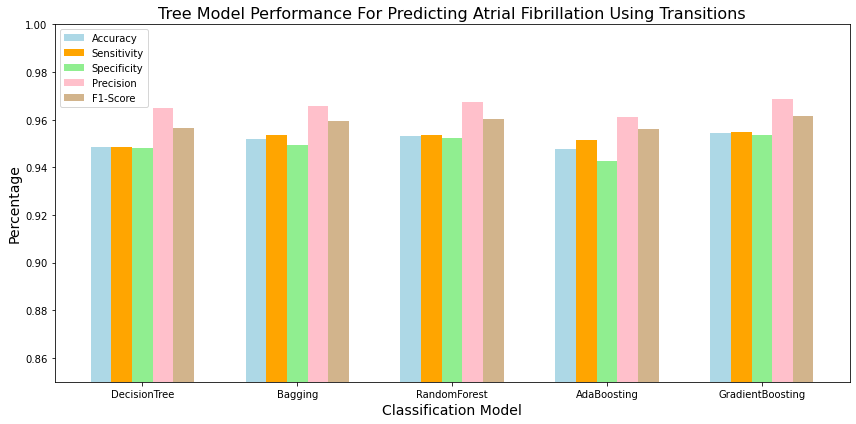

In [46]:
models = ['DecisionTree', 'Bagging', 'RandomForest', 'AdaBoosting', 'GradientBoosting']
accuracies = stattranstrees_dic["Accuracy"]
sensitivities = stattranstrees_dic["Sensitivity"]
specificities = stattranstrees_dic["Specificity"]
precisions = stattranstrees_dic["Precision"]
f1_scores = stattranstrees_dic["F1-Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color="lightblue")
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color="orange")
spe = ax.bar(x,specificities, width, label='Specificity', color="lightgreen")
pre = ax.bar(x+width, precisions, width, label='Precision', color="pink")
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1-Score', color="tan")

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Tree Model Performance For Predicting Atrial Fibrillation Using Transitions', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set(ylim=(0.85, 1.0))
ax.legend()

#ax.bar_label(acc, padding=3)
#ax.bar_label(sen, padding=3)
#ax.bar_label(spe, padding=3)
#ax.bar_label(pre, padding=3)
#ax.bar_label(f1, padding=3)


fig.tight_layout()

plt.legend(loc="upper left")
plt.show()

fig.savefig('TransitionTreeResults.png')
#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

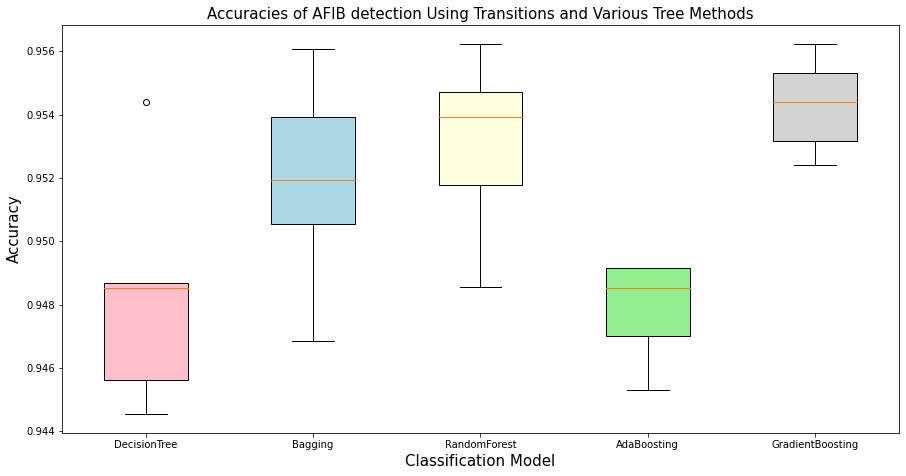

In [44]:
#Box Plot Accuracies

models = ['DecisionTree', 'Bagging', 'RandomForest', 'AdaBoosting', 'GradientBoosting']

x = np.arange(len(models))+1

DTAcc = indaccs_dic['Decision Tree']
BagAcc = indaccs_dic['Bagging']
RFAcc = indaccs_dic['Random Forest']
AdaBAcc = indaccs_dic['Ada Boosting']
GraBAcc = indaccs_dic['Gradient Boosting']

data = [DTAcc, BagAcc, RFAcc, AdaBAcc, GraBAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)


ax.set_title('Accuracies of AFIB detection Using Transitions and Various Tree Methods', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

colors = ['pink', 'lightblue', 'lightyellow', 'lightgreen', 'lightgrey']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

fig.savefig('TransitionTreeAccuraciesBoxPlots.png')